In [483]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_blobs
from sklearn.metrics import classification_report, accuracy_score
import sklearn
from sklearn.utils import shuffle
import xgboost as xgb

**Problématique choisie :** Est-il possible de prévoir quelles variables physiques permettent de remporter des médailles ?

# Présentation du data set

In [484]:
rawData = pd.read_csv("dataset/athlete_events.csv")

rawData.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


In [485]:
rawData.describe()

,ID,Age,Height,Weight,Year
count,271116.000000,261642.000000,210945.000000,208241.000000,271116.000000
mean,68248.954396,25.556898,175.338970,70.702393,1978.378480
std,39022.286345,6.393561,10.518462,14.348020,29.877632
min,1.000000,10.000000,127.000000,25.000000,1896.000000
25%,34643.000000,21.000000,168.000000,60.000000,1960.000000
50%,68205.000000,24.000000,175.000000,70.000000,1988.000000
75%,102097.250000,28.000000,183.000000,79.000000,2002.000000
max,135571.000000,97.000000,226.000000,214.000000,2016.000000


## Les variables


- ID : Identifiant unique pour chacun des athlètes
- Name : Nom de l'athlète
- Sex : Sexe de l'athlète (M ou F)
- Age : Age de l'athlète
- Height : Taille en centimètres de l'athlète
- Weight : Poids en kilogrammes de l'athlète
- Team : Pays de l'athlète
- NOC : Identifiant en trois lettre du pays
- Games : Année et saison des JO
- Year : Année de participation
- Season : "Summer" ou "Winter"
- City : Ville hôte
- Sport : Sport de l'épreuve
- Event : Nom de l'évènement
- Medal : Type de médaille remportée : Gold, Silver, Bronze, ou NA si rien n'a été gagné par l'athlète

### Variables utlisées dans le cadre de la résolution de la problématique
Les variables qui seront utlisées dans le cadre de la résolution de la problématique seront;
Pour décrire physiquement l'athlète:
- Age
- Height
- Weight

Pour catégoriser les athlètes:
- Sport

Pour évaluer la réussite de l'athlète:
- Medal

### Descriptions graphiques des variables

#### Taille / Poids / Age

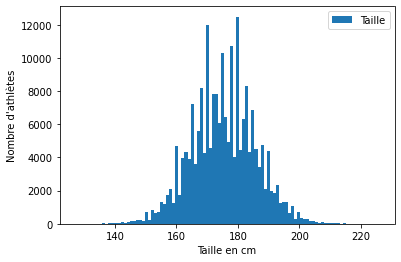

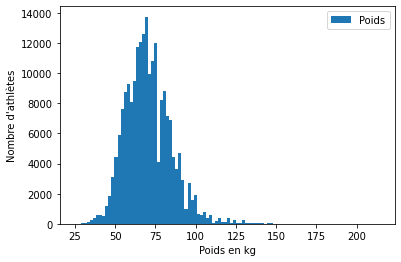

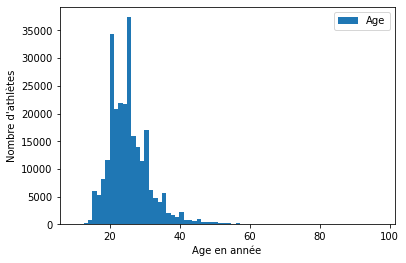

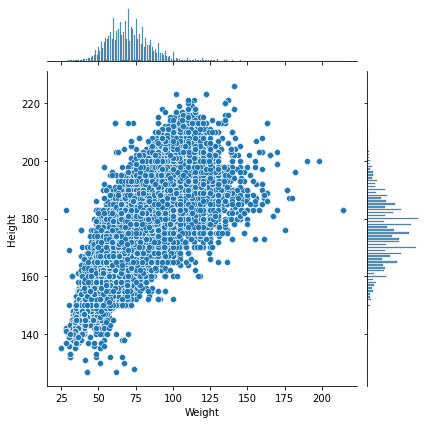

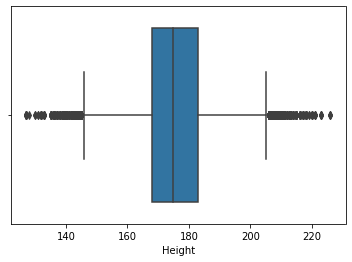

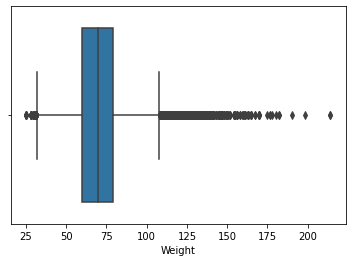

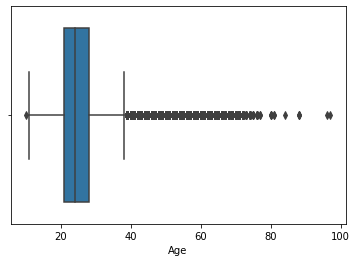

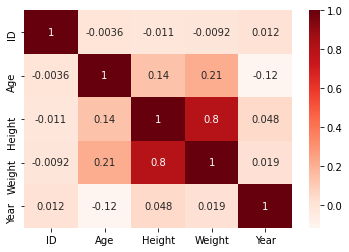

In [486]:

plt.hist(rawData["Height"], bins=100, label=['Taille'])
plt.legend(loc="upper right")
plt.xlabel('Taille en cm')
plt.ylabel("Nombre d'athlètes")
plt.show()

plt.hist(rawData["Weight"], bins=100, label=['Poids'])
plt.legend(loc="upper right")
plt.xlabel('Poids en kg')
plt.ylabel("Nombre d'athlètes")
plt.show()

plt.hist(rawData["Age"], bins=70, label=['Age'])
plt.legend(loc="upper right")
plt.xlabel('Age en année')
plt.ylabel("Nombre d'athlètes")
plt.show()

sns.jointplot(x=rawData["Weight"],y=rawData["Height"])
plt.show()

sns.boxplot(x=rawData["Height"])
plt.show()

sns.boxplot(x=rawData["Weight"])
plt.show()

sns.boxplot(x=rawData["Age"])
plt.show()

cor = rawData.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

# carafoot=rawData.loc[(rawData['Sport'] == "Football") ]
# # data.loc[(data['dropoff_latitude'] > 40.5) & (data['passenger_count'] == 2), 'fare_amount'].head()
# # print(carafoot)
# plt.hist(carafoot["Height"],bins=70, label=['Taille'])
# plt.legend(loc="upper right")
# plt.xlabel('Age en année')
# plt.ylabel("Nombre d'athlètes")
# plt.show()


# carafoot=rawData.loc[(rawData['Sport'] == "Basketball") ]
# # data.loc[(data['dropoff_latitude'] > 40.5) & (data['passenger_count'] == 2), 'fare_amount'].head()
# # print(carafoot)
# plt.hist(carafoot["Height"],bins=70, label=['Taille'])
# plt.legend(loc="upper right")
# plt.xlabel('Age en année')
# plt.ylabel("Nombre d'athlètes")
# plt.show()

# Nettoyage des données

Données qu'on considère comme ne pouvant pas être null à cause :

**Du non sens physique**
 - Age
 - Height
 - Weight
 - Sex


**Pour les besoins du process de traitement**
 - Sport

Et puis dans un deuxième temps:
En observant la répartition des données dans les boîtes à moustaches ci-dessus,
on peut remarquer certaines données qui sortent beaucoup trop du lot, et les retirer pour
ne pas qu'elles risquent d'affaiblir la précision de nos modèles.
Ainsi dans le poids on peut remarquer un point à l'extrémité droite causé par un participant 
de Judo pesant 220 kg, que l'on va retirer.

In [488]:
rawData.isnull()

print("Taille pré nettoyage :" + str(len(rawData)))

# Suppression des colonnes inutiles
rawData = rawData.drop(["Name", "Team", "NOC", "Games", "Year", "Season", "City", "Event"], axis=1)

#enlevement valeur aberrante de poids observée dans la boîte à moustache ci-dessus
print("avant nettoyage du poids:",rawData.shape)
ID = rawData['Weight'].idxmax()
heavy=rawData.iloc[ID]
rawData.drop(rawData[rawData["ID"] == heavy["ID"]].index, inplace=True)
print("après nettoyage du poids:",rawData.shape)



# Filtre sur les data null
clearData = rawData[(rawData["Height"].isnull() == False) & \
                    (rawData["Age"].isnull() == False) & \
                    (rawData["Weight"].isnull() == False) & \
                    (rawData["Sex"].isnull() == False) & \
                    (rawData["Sport"].isnull() == False)
                    ]
print("Taille post nettoyage :" + str(len(clearData)))
print("Il y'a donc une perte de " + str(len(rawData) - len(clearData)))
clearData.head()

Taille pré nettoyage :271116
avant nettoyage du poids: (271116, 7)
après nettoyage du poids: (271114, 7)
Taille post nettoyage :206163
Il y'a donc une perte de 64951


,ID,Sex,Age,Height,Weight,Sport,Medal
0,1,M,24.0,180.0,80.0,Basketball,NaN
1,2,M,23.0,170.0,60.0,Judo,NaN
4,5,F,21.0,185.0,82.0,Speed Skating,NaN
5,5,F,21.0,185.0,82.0,Speed Skating,NaN
6,5,F,25.0,185.0,82.0,Speed Skating,NaN


# Normalisation et encodage des données

## Normalisation Taille / Poids / Age

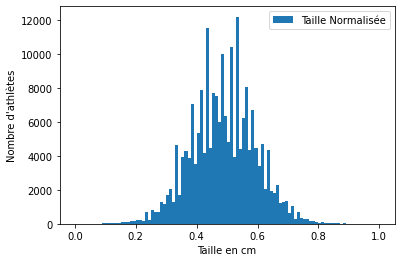

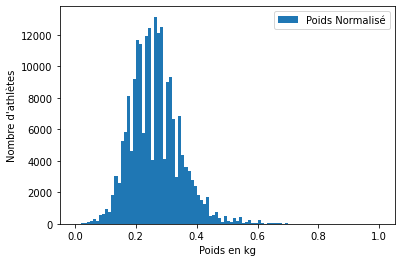

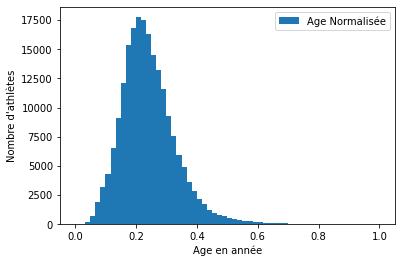

In [489]:
#normalisation de l'age 
clearData = clearData.copy()
data_age = clearData["Age"].copy()
min_age = (data_age-data_age.min())
max_age = (data_age.max()-data_age.min())
res = (min_age)/(max_age)*1
clearData["Age"] = res

#normalisation du poids
clearData = clearData.copy()
data_age = clearData["Weight"].copy()
min_age = (data_age-data_age.min())
max_age = (data_age.max()-data_age.min())
res = (min_age)/(max_age)*1
clearData["Weight"] = res

#normalisation de la taille
clearData = clearData.copy()
data_age = clearData["Height"].copy()
min_age = (data_age-data_age.min())
max_age = (data_age.max()-data_age.min())
res = (min_age)/(max_age)*1
clearData["Height"] = res



plt.hist(clearData["Height"], bins=100, label=['Taille Normalisée'])
plt.legend(loc="upper right")
plt.xlabel('Taille en cm')
plt.ylabel("Nombre d'athlètes")
plt.show()

plt.hist(clearData["Weight"], bins=100, label=['Poids Normalisé'])
plt.legend(loc="upper right")
plt.xlabel('Poids en kg')
plt.ylabel("Nombre d'athlètes")
plt.show()

plt.hist(clearData["Age"], bins=60, label=['Age Normalisée'])
plt.legend(loc="upper right")
plt.xlabel('Age en année')
plt.ylabel("Nombre d'athlètes")
plt.show()

clearData.loc[(clearData["Medal"].isnull() == False), 'Medal'] = 1
clearData.loc[(clearData["Medal"].isnull() == True), 'Medal'] = 0

clearData.loc[(clearData["Sex"]== "M"), 'Sex'] = 1
clearData.loc[(clearData["Sex"]== "F"), 'Sex'] = 0


# Regression logistique (Tous sports confondus)

In [490]:
print("Nombre de médaillés : " + str(len(clearData[clearData["Medal"] == 1])))

print("Nombre de non-médaillés : " + str(len(clearData[clearData["Medal"] == 0])))

Nombre de médaillés : 30181
Nombre de non-médaillés : 175982


In [491]:
reglog = LogisticRegression(solver="lbfgs", penalty="none", max_iter=300)

relog_clearData = clearData.drop(["Sport", "ID"], axis=1)


X = relog_clearData.drop(["Medal"], axis=1)
Y = relog_clearData["Medal"].astype(int)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, shuffle=True, train_size=0.8, random_state=42)


reglog = reglog.fit(X_train, Y_train)

print('Coefficients: ', reglog.coef_)

predicted_classes = reglog.predict(X_test)
accuracy = accuracy_score(Y_test,predicted_classes)

print('Accuracy (%): ', accuracy * 100)

print(classification_report(Y_test,predicted_classes))

Coefficients:  [[-0.5846615   0.64845035  2.21177817  2.22634444]]
Accuracy (%):  85.27150583270682
              precision    recall  f1-score   support

           0       0.85      1.00      0.92     35161
           1       0.40      0.00      0.00      6072

    accuracy                           0.85     41233
   macro avg       0.63      0.50      0.46     41233
weighted avg       0.79      0.85      0.79     41233



### Analyse sans modification de l'échantillonage

Dans ce modèle, on observe que le modèle fait des prédictions justes uniquement dans le cas de la classe 0, celle représentant les athlètes ne remportant pas de médaille.
Dans 78% des cas ces prédictions, et uniquement celle-ci, s'avèrent juste. On observe aussi un taux de 100% de rappel ce qui signifie que le modèle ne crée **aucun faux négatif dans la classe 0**.  
Par contre dans la classe 1 on observe une précision de 0% et un rappel de 0%. Cela qui signifie que le modèle n'arrive pas du tout a prédire de résultat dans la classe 1, dans la classe des athlètes gagnant des médailles.

Cette incapacité à prédire quoi que ce soit de bon dans le second cas - alors que pour la classe 0 les résultats sont plutôt honorables - s'explique par la présence dans le dataset d'une quantité très importante d'athlètes n'ayant rien remporté.

Bien que ce genre de problème semble indiquer que le modèle utilisé n'est pas adapté à l'étude de ce dataset, nous allons dans un premier temps effectuer un sous-échantillonage des athlètes n'ayant rien remporté pour que le ratio médaillé/non-médaillé soit plus important.

### Expérimentation du dataset ré-échantilloné

In [492]:
lenCD = int(len(clearData[clearData.Medal == 1])*0.65)

sampleData = pd.concat([clearData[clearData.Medal == 1], clearData[clearData.Medal == 0].sample(lenCD)])

reglog = LogisticRegression(solver="lbfgs", penalty="none", max_iter=300)



X = sampleData.drop(["Medal", "Sport"], axis=1)
Y = sampleData["Medal"].astype(int)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, shuffle=True, train_size=0.8, random_state=42)


reglog = reglog.fit(X_train, Y_train)

print('Coefficients: ', reglog.coef_)

predicted_classes = reglog.predict(X_test)
accuracy = accuracy_score(Y_test,predicted_classes)

print('Accuracy (%): ', accuracy * 100)

print(classification_report(Y_test,predicted_classes))

Coefficients:  [[5.14366298e-06 1.81379615e-10 1.17638212e-10 2.98235344e-10
  1.85084669e-10]]
Accuracy (%):  60.080321285140556
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3976
           1       0.60      1.00      0.75      5984

    accuracy                           0.60      9960
   macro avg       0.30      0.50      0.38      9960
weighted avg       0.36      0.60      0.45      9960



C:\Users\bukle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bukle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bukle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1248: Unde

### Analyse du dataset ré-échantilloné

En rééchantillonant le nombre d'athlètes non médaillés, on remarque que la précision est 18pts plus basse que durant le dernier entrainement. Néanmoins, on remaque que pour la classe 0 on obtient une précision de 52% ce qui signifie que le modèle se trompe quasiment une fois sur deux et a un rappel de 2%. Il identifie donc seulement 2% des athlètes non médaillés correctement.

Pour la classe 1, la classe des athlètes médaillés, on observe une précision de 61% et un rappel de 99%.

Le ré-échantillonement permet donc une nette amélioration pour l'identification des athlètes remportant des médailles mais une chute drastique de la qualité d'identification de ceux qui n'en gagnent pas. 

Il est à noter que la quantité d'ahtlètes non médaillés a été choisie de façon empirique et est liée à une série d'observations.

## Conclusion des analyses

Bien que le ré-échantillonement permette d'améliorer la détection des athlètes gagnant une médaille, cette amélioration n'est pas suffisante pour permettre de dire que ce modèle est le plus efficace pour l'étude de ce dataset. De plus, sa faible capacité à identifier ceux qui ne seront pas médaillés renforce cette conclusion.

# ETUDE ECHANTILLON DE NATATION

L'isolation des athlètes ayant fait de la natation répond a une volonté de vouloir tester les modèles sur un plus petit ensemble de sportifs et cela dans un sport individuel. 
La raison pour laquelle il est utile de séléctionner un sport individuel est que cela permet d'éviter les biais liés à la présence du participant dans une équipe. 

In [493]:
#on recup les events de Natation
sport=clearData.loc[(clearData["Sport"]=="Swimming")]

#on drop les colonnes qui ne nous intéressent pas
sport=sport.drop(["Sport"], axis=1)
sport=sport.drop(["ID"], axis=1)

#on sépare les wins et looses pour les échantilloner également
wins=sport.loc[(sport["Medal"]==1)] 
losses=sport.loc[(sport["Medal"]==0)] 
losses=losses.sample(len(wins) )
# footL.reset_index()
sport=pd.concat([losses,wins])

#mélange
sport = shuffle(sport)


sport.head(10)

,Sex,Age,Height,Weight,Medal
176482,0,0.250000,0.393939,0.173410,0
154036,0,0.100000,0.505051,0.236994,1
257833,0,0.116667,0.424242,0.173410,1
40241,1,0.233333,0.636364,0.352601,0
125935,1,0.166667,0.535354,0.294798,1
46265,0,0.100000,0.434343,0.202312,0
122025,0,0.066667,0.535354,0.242775,1
176771,1,0.266667,0.686869,0.329480,1
201901,1,0.200000,0.515152,0.277457,1
217384,0,0.166667,0.434343,0.219653,0


# REGRESSION LOGISTIQUE (natation)

In [494]:

reglog = LogisticRegression(solver="lbfgs", penalty="none", max_iter=300)

X = sport.drop(["Medal"], axis=1)
Y = sport["Medal"].astype(int)

print(X.shape)
print(Y.shape)


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, shuffle=True, train_size=0.8, random_state=42)


reglog = reglog.fit(X_train, Y_train)

print('Coefficients: ', reglog.coef_)

predicted_classes = reglog.predict(X_test)
accuracy = accuracy_score(Y_test,predicted_classes)

print('Accuracy (%): ', accuracy * 100)

print(classification_report(Y_test,predicted_classes))

(4972, 4)
(4972,)
Coefficients:  [[-1.1321213   0.6588078   2.91122235  6.49989274]]
Accuracy (%):  59.497487437185924
              precision    recall  f1-score   support

           0       0.58      0.61      0.59       482
           1       0.61      0.58      0.60       513

    accuracy                           0.59       995
   macro avg       0.60      0.60      0.59       995
weighted avg       0.60      0.59      0.60       995



## Analyse

On observe que les modèles arrivent à prédire avec une précision et un rappel relativement proches les deux classes, bien que ces deux taux soient au-dessus de 50 signifiant une véritable prédiction, ils en restent assez proche. 
Mis à part une amélioration des prédictions dans les deux classes, ce modèle avec ce dataset ne permet pas de tirer de nettes prédictions du dataset.

## Conclusion de l'analyse

Pour continuer de tenter de prévoir les meilleures conditions physiques permettant de remporter une médaille, il est a priori nescessaire de changer de modèle. En effet, la régression logistique ne semble pas apporter de réponse claire.

# RANDOM FOREST (BAGGING) (natation)

In [495]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
classifier = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
classifier.fit(X_train, Y_train) # On peut mettre Y_train ou Y_train_lb. Pourquoi ?



predicted_classes = classifier.predict(X_test)
accuracy = accuracy_score(Y_test,predicted_classes)

print('Accuracy (%): ', accuracy * 100)

print(classification_report(Y_test,predicted_classes))

Accuracy (%):  65.22613065326634
              precision    recall  f1-score   support

           0       0.67      0.60      0.63       495
           1       0.64      0.70      0.67       500

    accuracy                           0.65       995
   macro avg       0.65      0.65      0.65       995
weighted avg       0.65      0.65      0.65       995



## Analyse
En utilisant l'algorithme de random forest, nous améliorons la précision et le rappel de notre modèle. En effet, on peut observer ici un gain de 5 et 6 pts pour les précisions ainsi que 7 et 4 pour les rappels respectivement pour les classes 0 et 1. 
Nous avons donc ici de meilleurs résultats qu'avec la régression linéaire. Cela peut s'expliquer par le fait que les forêts aléatoires sont moins sensibles à la variance des données et parent mieux le sur-apprentissage (réduit ici par le ré-échantillonage).


## Conclusion de l'analyse
Bien que la forêt aléatoire semble améliorer nos résultats, ces résultats restent toutefois peu fiables pour vouloir continuer à chercher un nouveau modèle à appliquer sur le dataset et affiner nos prévisions.

# BOOSTING (natation)

In [496]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

# print(X)
# print(Y)

from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(max_depth=3, n_estimators=20, random_state=42)
regressor.fit(X_train, Y_train)

from sklearn.metrics import mean_squared_error, mean_absolute_error

# score = np.sqrt(mean_squared_error(Y_test, regressor.predict(X_test)))
# print('RMSE: ',score)
# score = mean_absolute_error(Y_test, regressor.predict(X_test))
# print('MAE: ',score)

X_train["Sex"]=X_train["Sex"].astype("int")
param = {'max_depth':7, 'eta':0.1, 'silent':1, 'objective':'binary:logistic',
         'n_estimators': 500,
        'learning_rate': 0.01,
        'gamma': 0.1}
booster = xgb.XGBClassifier(**param)
booster.fit(X_train, Y_train)


predicted_classes = booster.predict(X_test)
accuracy = accuracy_score(Y_test,predicted_classes)

print('Accuracy (%): ', accuracy * 100)

print(classification_report(Y_test,predicted_classes))

C:\Users\bukle\AppData\Local\Temp/ipykernel_4704/1732949139.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train["Sex"]=X_train["Sex"].astype("int")
C:\Users\bukle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:13:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:13:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy (%):  62.51256281407035
              precision    recall  f1-score   support

           0       0.65      0.57      0.61       506
           1       0.60      0.69      0.64       489

    accuracy                           0.63       995
   macro avg       0.63      0.63      0.62       995

### Analyse 
Nous n'observons qu'une ténue amélioration de nos résultats. En effet, seule la précision des prédictions sur la classe 0, classe qui nous intéresse le moins à prédire par ailleurs, s'est améliorée. Tout le reste est plus bas. Nous avons des résultats de moins bonne qualité. 

### Conclusion de l'analyse
Il semblerait que le modèle du boosting ne soit pas plus adapté que la forêt aléatoire à ce dataset. 

# ETUDE ECHANTILLON SPORTS INDIVIDUELS

In [497]:
#j'ai testé en enlevant les sports avec des catégories de poids ca monte un peu le score ~3-4 %

individuels=[
'Alpine Skiing',
 'Archery',
 'Art Competitions',
 'Athletics',
 'Biathlon',
#  'Boxing',
 'Cross Country Skiing',
 'Cycling',
 'Diving',
 'Equestrianism',
 'Fencing',
 'Figure Skating',
 'Freestyle Skiing',
 'Golf',
 'Gymnastics',
#  'Judo',
 'Luge',
 'Modern Pentathlon',
 'Motorboating',
 'Rhythmic Gymnastics',
 'Sailing',
 'Shooting',
 'Short Track Speed Skating',
 'Skeleton',
 'Ski Jumping',
 'Snowboarding',
 'Speed Skating',
 'Swimming',
 'Table Tennis',
#  'Taekwondo',
 'Tennis',
 'Trampolining',
 'Triathlon',
 'Weightlifting',
#  'Wrestling'
]

sportsIndividuels=clearData.loc[clearData['Sport'].isin(individuels)]


#on drop les colonnes qui ne ous interessent pas
sportsIndividuels=sportsIndividuels.drop(["Sport"], axis=1)
sportsIndividuels=sportsIndividuels.drop(["ID"], axis=1)

Suite à l'étude sur la natation, il est apparu que les résultats sur ce sport sont révélés bien meilleurs que sur l'intégralité du dataset. Nous allons donc procéder à une augmentation des données injectées dans les différents modèles tout en faisant en sorte que ce ne soit que des athlètes ayant concouru dans des sports individuels. Cette catégorie de sport est ainsi plus logique à étudier dans le cadre de l'étude des seules constantes physisques d'un athlète (le jeu d'équipe primordial dans un jeu à plusieurs joueurs ne transparais pas dans ces constantes). 

# Partie pour échantilloner les non-médaillés en fonction des médaillés

In [498]:
wins=sportsIndividuels.loc[(sportsIndividuels["Medal"]==1)] 

print(wins.shape)

losses=sportsIndividuels.loc[(sportsIndividuels["Medal"]==0)] 
losses=losses.sample(int(len(wins)*4) )

#concat
sportsIndividuels=pd.concat([losses,wins])
#mélange
sportsIndividuels = shuffle(sportsIndividuels)


sportsIndividuels.shape

(15873, 5)


(79365, 5)

# REGRESSION LOGISTIQUE (SPORTS INDIVIDUELS)

In [499]:

reglog = LogisticRegression(solver="lbfgs", penalty="none", max_iter=300)

X = sportsIndividuels.drop(["Medal"], axis=1)
Y = sportsIndividuels["Medal"].astype(int)

print(X.shape)
print(Y.shape)


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, shuffle=True, train_size=0.8, random_state=42)


reglog = reglog.fit(X_train, Y_train)

print('Coefficients: ', reglog.coef_)

predicted_classes = reglog.predict(X_test)
accuracy = accuracy_score(Y_test,predicted_classes)

print('Accuracy (%): ', accuracy * 100)

print(classification_report(Y_test,predicted_classes))

(79365, 4)
(79365,)
Coefficients:  [[-0.43821178  0.42692055  2.1911374   1.15954887]]
Accuracy (%):  80.06678006678007
              precision    recall  f1-score   support

           0       0.80      1.00      0.89     12709
           1       0.00      0.00      0.00      3164

    accuracy                           0.80     15873
   macro avg       0.40      0.50      0.44     15873
weighted avg       0.64      0.80      0.71     15873



C:\Users\bukle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bukle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bukle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1248: Unde

## Analyse

On observe une précision de 80% pour la classe 1 et un rappel de 100% ce qui signifie que le modèle ne se trompe que très peu en prédisant une classe 0. Cepandant, le modèle se trompe 100% du temps pour la classe 1, chose qui est problématique car c'est précisèment les éléments entrant dans la classe 1 que nous souhaitons prédire.

## Conclusion de l'analyse

Avec des résultats aussi catastrophiques il est impossible d'utiliser le modèle de la régression logisitique pour étudier ce dataset.

# RANDOM FOREST (BAGGING) (SPORTS INDIVIDUELS)

# Prédiction des conditions physiques permettant d'accéder au podium

In [500]:
print("Nombre de médaillés : " + str(len(clearData[clearData["Medal"] == 1])))

print("Nombre de non-médaillés : " + str(len(clearData[clearData["Medal"] == 0])))

Nombre de médaillés : 30181
Nombre de non-médaillés : 175982


In [501]:
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

reglog = LogisticRegression(solver="lbfgs", penalty="none", max_iter=300)

X = clearData.drop(["Medal"], axis=1)
Y = clearData["Medal"].astype(int)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, shuffle=True, train_size=0.8, random_state=42)


reglog = reglog.fit(X_train, Y_train)

print('Coefficients: ', reglog.coef_)

predicted_classes = reglog.predict(X_test)
accuracy = accuracy_score(Y_test,predicted_classes)

print('Accuracy (%): ', accuracy * 100)

print(classification_report(Y_test,predicted_classes))

ValueError: could not convert string to float: 'Cross Country Skiing'

In [ ]:
lenCD = int(len(clearData[clearData.Medal == 1])*0.65)

sampleData = pd.concat([clearData[clearData.Medal == 1], clearData[clearData.Medal == 0].sample(lenCD)])

reglog = LogisticRegression(solver="lbfgs", penalty="none", max_iter=300)

X = sampleData.drop(["Medal"], axis=1)
Y = sampleData["Medal"].astype(int)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, shuffle=True, train_size=0.8, random_state=42)


reglog = reglog.fit(X_train, Y_train)

print('Coefficients: ', reglog.coef_)

predicted_classes = reglog.predict(X_test)
accuracy = accuracy_score(Y_test,predicted_classes)

print('Accuracy (%): ', accuracy * 100)

print(classification_report(Y_test,predicted_classes))

Coefficients:  [[-0.3281155  -0.4709259   1.78627192  0.46135788  0.00374539]]
Accuracy (%):  60.79582517938682
              precision    recall  f1-score   support

           0       0.52      0.02      0.04      3612
           1       0.61      0.99      0.75      5586

    accuracy                           0.61      9198
   macro avg       0.56      0.50      0.40      9198
weighted avg       0.57      0.61      0.47      9198



In [ ]:
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
classifier = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
classifier.fit(X_train, Y_train) # On peut mettre Y_train ou Y_train_lb. Pourquoi ?



predicted_classes = classifier.predict(X_test)
accuracy = accuracy_score(Y_test,predicted_classes)

print('Accuracy (%): ', accuracy * 100)

print(classification_report(Y_test,predicted_classes))

Accuracy (%):  79.86517986517987
              precision    recall  f1-score   support

           0       0.80      1.00      0.89     12666
           1       0.60      0.01      0.02      3207

    accuracy                           0.80     15873
   macro avg       0.70      0.50      0.45     15873
weighted avg       0.76      0.80      0.71     15873



## Analyse

On observe des précisions de 80% et 60% ainsi qu'un rappel de 100% et 1% pour les classes 0 et 1. 


## Conclusion de l'analyse

Cela signifie que le modèle est excellent pour prédire quelles constantes physiques ne permettent pas de gagner de médaille.

# BOOSTING (SPORTS INDIVIDUELS)

In [ ]:
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

# print(X)
# print(Y)

from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(max_depth=3, n_estimators=20, random_state=42)
regressor.fit(X_train, Y_train)

# from sklearn.metrics import mean_squared_error, mean_absolute_error

# score = np.sqrt(mean_squared_error(Y_test, regressor.predict(X_test)))
# print('RMSE: ',score)
# score = mean_absolute_error(Y_test, regressor.predict(X_test))
# print('MAE: ',score)

X_train["Sex"]=X_train["Sex"].astype("int")
param = {'max_depth':10, 'eta':0.1, 'silent':1, 'objective':'binary:logistic',
         'n_estimators': 500,
        'learning_rate': 0.01,
        'gamma': 0.2}
booster = xgb.XGBClassifier(**param)
booster.fit(X_train, Y_train)


predicted_classes = booster.predict(X_test)
accuracy = accuracy_score(Y_test,predicted_classes)

print('Accuracy (%): ', accuracy * 100)

print(classification_report(Y_test,predicted_classes))

C:\Users\Theo\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Theo\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:37:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:37:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy (%):  79.83367983367984
              precision    recall  f1-score   support

           0       0.80      1.00      0.89     12666
           1       0.53      0.02      0.03      3207

    accuracy                           0.80     15873
   macro avg       0.66      0.51      0.46     15873

## Analyse

On observe des précisions de 80% et 53% ainsi qu'un rappel de 100% et 2% pour les classes 0 et 1. 

## Conclusion de l'analyse

Les résultats sont très semblables à ceux de la forêt aléatoire avec néanmoins une perte de qualité des résulats dans la classe 1.

# Problèmes rencontrés sur les données



## Quantité

Ce dataset nous donne une grande quantité de données (plus de 200 000 lignes tout de même) mais notre problématique nous demande d'étudier chaque sport, et donc de diviser drastiquement le nombre de lignes. En plus de cela, nous avons remarqué que dans notre échantillon, nous avons beaucoup trop de personnes non médaillées par rapport à celles médaillées (ce qui est logique, il y a beaucoup de participants, et le podium des 3 premiers en représente qu'une faible partie). Nos modèles avaient donc du mal à bien prédire.
Il a fallu enlever une partie des non médaillés, pour avoir une population un peu plus équivalente (un tier/deux tier) mais ce procédé renforce encore plus le problème de depart qui nous donne un petit échantillon.

## Cohérence des données avec la problématique

Notre problématique nous demande de travailler et de prédire sur les caractéristiques physiques. Or, certains sports et categories ont d'autres caractéristiques qui peuvent être prises en compte: on pense notamment aux sports collectifs, tel que le football et basketball par exemple, qui vont demander une certaine cohésion et travail d'équipe que l'on ne peut ni quantifier ni qualifier. C'est donc pour cette raison que nous avons décidé de travailler sur des sports individuels.

Les informations que nous avions sur les athlètes sont également limitées. Pour un athlète considéré, il aurait sans doute été intéréssant d'avoir son classement mondial pour les jeux auquels il a participés, son record personnel dans son épreuve avant d'y participer ou bien encore son coach.

**Malgré l'étude sur différents échantillons et avec différents modèles, aucune correlation forte n'a pu été trouvée entre les carctéristiques physiques des participants et leurs capacités à obtenir des médailles.**

## Conclusion finale

En conclusion, on pourra dire que notre problématique n'était peut être pas très adaptée à notre dataset. En effet, nous n'avons pas réussi à mettre en exergue une corrélation importante et ainsi à prédire les conditions physqiues optimales permettant de remporter des médailles.

Si notre étude de la problématique ne s'est pas soldée par une réussite, cela se veut tout de même rassurant dans la vie réelle. En effet, ce serait désolant d'être en mesure de prédire rééllement les résultats des jeux olympiques: si les seules caratéristiques physiques d'un athlète étaient un gage de déterminisme, il n'y aurait plus aucune raison pour ce dernier de participer dans le cas où il ne correspondrait pas aux critères supposés gagnants. Cela signifie que pour espérer gagner une médaille dans une compétition d'une telle envergure, il ne suffit pas d'avoir un pysique type et que l'équation de la victoire est en réalité bien plus complexe.  

# Améliorations possibles

Il serait sans doute possible d'améliorer nos résultats en poursuivant les recherches en affinant sport par sport, catégorie par catégorie en plaçant plus d'importance sur une variable plus qu'une autre en fonction du sport et de la catégorie.
De plus, il serait envisageable de croiser ces données avec d'autres datasets de manière à ajouter des données liées aux conditions physiques des athlètes.